# Introducción y Descripción de la Base de Datos

Este Notebook tiene como objetivo desarrollar un Processing Job en Amazon SageMaker que realice un análisis exploratorio (EDA) y feature engineering sobre un conjunto de datos CSV. 


## Descripción del Conjunto de Datos

El conjunto de datos **TestPad_PCB_XYRGB_V2.csv** fue utilizado originalmente para la recuperación de coordenadas de almohadillas de prueba a partir de imágenes de placas de circuitos impresos (PCB). Posee las siguientes características:

- **Variables de posición:**  
  - **X** e **Y**: Representan la posición de los píxeles en la imagen.
  
- **Variables de color:**  
  - **R, G y B:** Valores que indican el color de cada píxel. Estos valores se encuentran normalizados en un rango de 0 a 255.
  
- **Indicador de gris:**  
  - **Gris:** Este campo indica aquellos píxeles que son aproximadamente grises.

El conjunto de datos permite diversas aplicaciones, tales como:
- **Clasificación:** Por ejemplo, para la detección de almohadillas de prueba grises.
- **Detección de anomalías:** Como la identificación de almohadillas de prueba falsas.
- **Agrupamiento (clustering):** Para el descubrimiento de grandes grupos de almohadillas de prueba grises.

Este dataset se utilizó originalmente en el artículo:
> *Swee Chuan Tan y Schumann Tong Wei Kit, "Recuperaciones rápidas de coordenadas de almohadillas de prueba a partir de imágenes fotográficas de placas de circuitos impresos", 2016 International Conference on Advanced Mechatronic Systems (ICAMechS), pp. 464-467.*  
> [Enlace al artículo](https://api.semanticscholar.org/CorpusID:38544897)

Cabe destacar que este conjunto de datos contiene más píxeles que el presentado en el artículo, debido a un método de extracción diferente.

**El objetivo de esta tarea es:**  
- **Diseñar y ejecutar un Processing Job en Amazon SageMaker** que realice un análisis exploratorio (EDA) y feature engineering sobre el dataset.  
- **Configurar un entorno de trabajo en SageMaker,** estableciendo las rutas de entrada y salida en Amazon S3.  
- **Desarrollar un script en Python** que, como parte del Processing Job, lea el CSV, muestre estadísticas descriptivas, genere un reporte y guarde los resultados en S3.  
- **Demostrar la flexibilidad y potencia de los Processing Jobs** dentro del ciclo de vida del machine learning, facilitando la automatización y escalabilidad de procesos críticos, como la preparación de datos, que pueden integrarse posteriormente con pasos de entrenamiento, evaluación o inferencia.

Este flujo de trabajo permite preparar los datos de manera eficiente, garantizando que la información esté en el formato adecuado para pasos posteriores en un pipeline de MLOps.

# Configuración del Entorno

Importación de librerias

In [54]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import os

In [55]:
# Paso 1.1: Crear una sesión de SageMaker.
# Esta sesión es necesaria para interactuar con los servicios de SageMaker.
sagemaker_session = sagemaker.Session()

In [56]:
# Paso 1.2: Obtener el rol de ejecución.
# Este rol le otorga a SageMaker los permisos necesarios para acceder a otros servicios de AWS, como S3.
role = get_execution_role()

In [57]:
# Paso 1.3: Definir el bucket en S3.
bucket = "trabajonota2"


In [58]:
# Paso 1.4: Definir un prefijo (opcional) para organizar los archivos.
# Esto ayuda a mantener organizados los recursos generados por el Notebook.
prefix = "notebookProcessing"

In [59]:
# Paso 1.5: Definir la ruta completa del archivo CSV cargado.
# Se asume que el archivo TestPad_PCB_XYRGB_V2.csv está en la raíz del bucket.
input_data_uri = f"s3://{bucket}/TestPad_PCB_XYRGB_V2.csv"

In [60]:
# Paso 1.6: Definir la ruta de salida para los resultados del Processing Job.
# Esta es la carpeta donde se guardarán los archivos de salida generados por el job.
output_prefix = f"s3://{bucket}/{prefix}/output"

In [61]:
# Mostrar la configuración para confirmar que todo está correcto.
print("S3 Input URI:", input_data_uri)
print("S3 Output Prefix:", output_prefix)
print("IAM Role:", role)

S3 Input URI: s3://trabajonota2/TestPad_PCB_XYRGB_V2.csv
S3 Output Prefix: s3://trabajonota2/notebookProcessing/output
IAM Role: arn:aws:iam::442734717239:role/service-role/AmazonSageMaker-ExecutionRole-20250331T182193


In [62]:
# Crear un cliente para S3
s3_client = boto3.client('s3')

In [63]:
# Listar todos los objetos en el bucket "trabajonota2"
response = s3_client.list_objects_v2(Bucket=bucket)

In [64]:
# Verificar si se encontraron objetos
if 'Contents' in response:
    print("Archivos en el bucket:")
    files = [obj['Key'] for obj in response['Contents']]
    for key in files:
        print(" -", key)    
    # Comprobar si el archivo deseado está en la lista
    if "TestPad_PCB_XYRGB_V2.csv" in files:
        print("\nEl archivo 'TestPad_PCB_XYRGB_V2.csv' se encontró correctamente.")
    else:
        print("\nEl archivo 'TestPad_PCB_XYRGB_V2.csv' NO se encontró. Revisa la ruta o súbelo nuevamente.")
else:
    print("No se encontraron archivos en el bucket.")

Archivos en el bucket:
 - TestPad_PCB_XYRGB_V2.csv

El archivo 'TestPad_PCB_XYRGB_V2.csv' se encontró correctamente.


# EDA

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
import os


In [66]:
# Configurar opciones de pandas para mostrar toda la información
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)

In [67]:
# Ruta completa en S3
csv_path = "s3://trabajonota2/TestPad_PCB_XYRGB_V2.csv"
print("Leyendo el dataset desde:", csv_path)

Leyendo el dataset desde: s3://trabajonota2/TestPad_PCB_XYRGB_V2.csv


In [68]:
# Leer directamente desde S3
df = pd.read_csv(csv_path)


In [69]:
# Mostrar las primeras filas del dataset
print("Primeras 5 filas del dataset:")
print(df.head())

Primeras 5 filas del dataset:
     X  Y         R         G         B  Grey
0  105  0  0.909804  0.976471  0.937255     0
1  106  0  0.792157  0.901961  0.843137     0
2  107  0  0.631373  0.788235  0.694118     0
3  108  0  0.474510  0.670588  0.556863     0
4  109  0  0.341176  0.584314  0.439216     0


In [70]:
# Información general del dataset
print("\nInformación del dataset:")
print(df.info())


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723552 entries, 0 to 723551
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X       723552 non-null  int64  
 1   Y       723552 non-null  int64  
 2   R       723552 non-null  float64
 3   G       723552 non-null  float64
 4   B       723552 non-null  float64
 5   Grey    723552 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 33.1 MB
None


In [71]:
# === Análisis de columnas categóricas ===
print("\n=== FRECUENCIAS DE COLUMNAS CATEGÓRICAS ===")
for col in df.select_dtypes(include=['object']).columns:
    print(f"Frecuencias para {col}:")
    print(df[col].value_counts(normalize=True))
    print("\n")


=== FRECUENCIAS DE COLUMNAS CATEGÓRICAS ===



=== HISTOGRAMAS DE COLUMNAS NUMÉRICAS ===
Histograma para X:


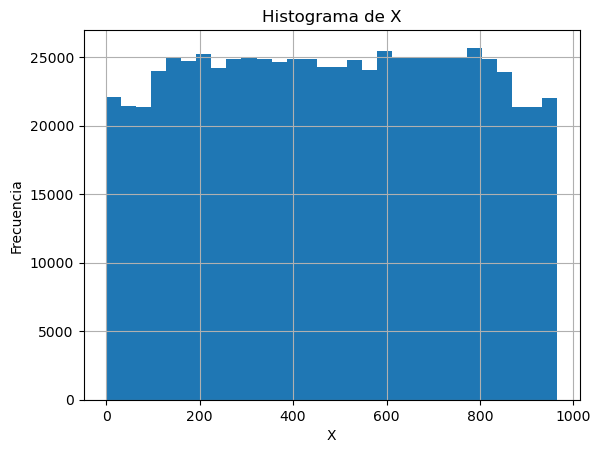

Histograma para Y:


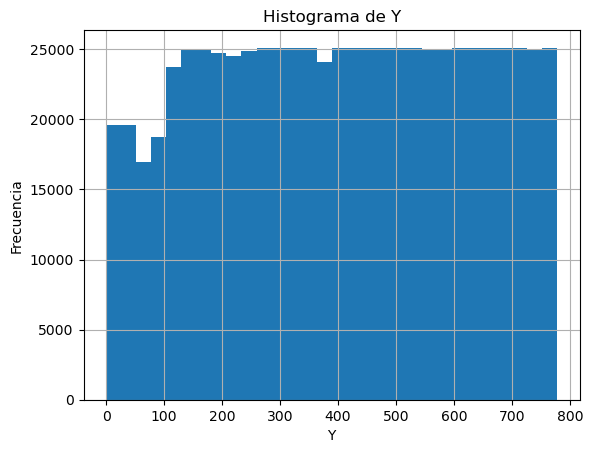

Histograma para R:


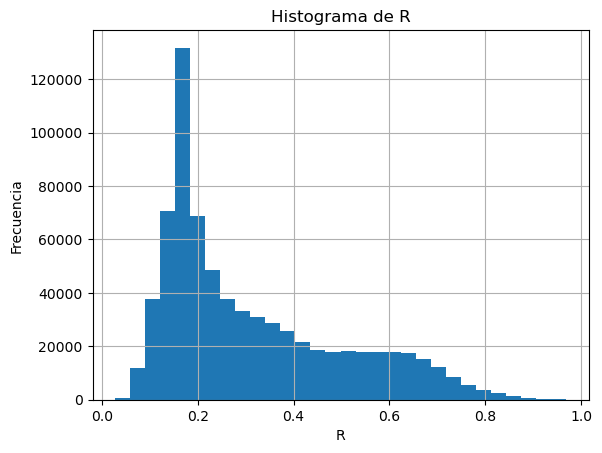

Histograma para G:


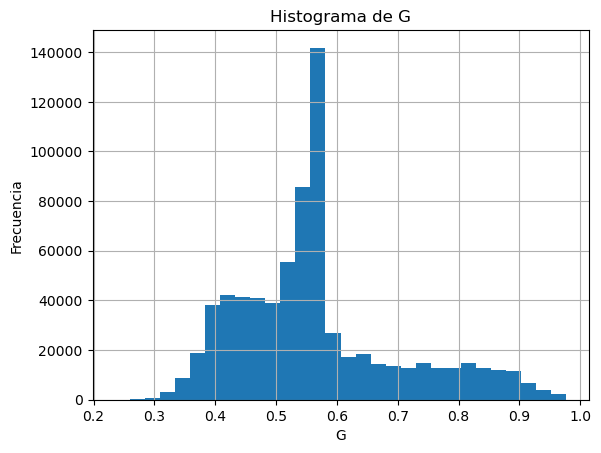

Histograma para B:


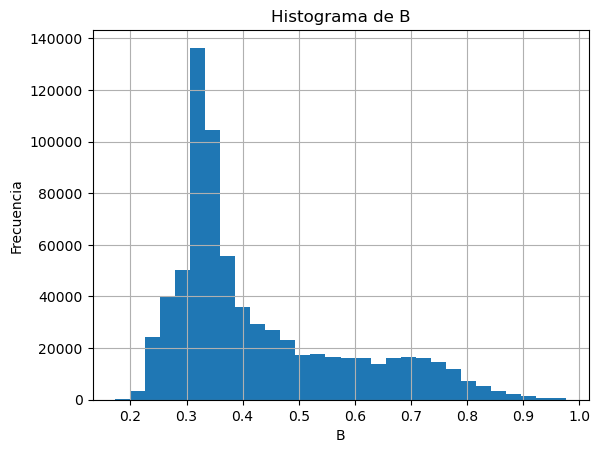

Histograma para Grey:


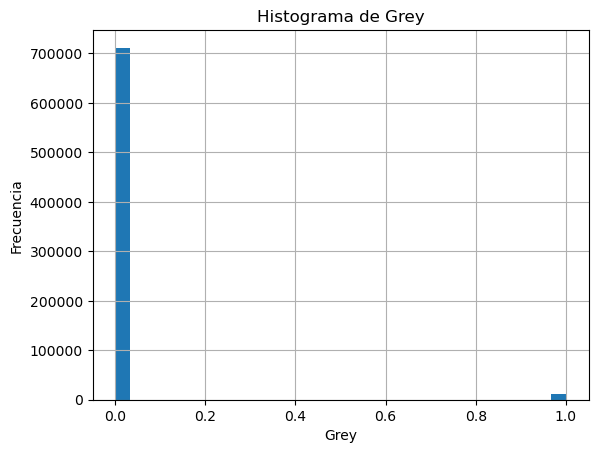

In [72]:
# === Análisis de columnas numéricas: Histogramas ===
print("\n=== HISTOGRAMAS DE COLUMNAS NUMÉRICAS ===")
for col in df.select_dtypes(include=[np.number]).columns:
    print(f"Histograma para {col}:")
    df[col].hist(bins=30)
    plt.title(f"Histograma de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()


In [73]:
# === Transformación: Crear columna 'avg_color' si existen las columnas R, G y B ===
if all(col in df.columns for col in ["R", "G", "B"]):
    df["avg_color"] = df[["R", "G", "B"]].mean(axis=1)
    print("Columna 'avg_color' creada (promedio de R, G y B)")

Columna 'avg_color' creada (promedio de R, G y B)


In [74]:
# Mostrar estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(df.describe())



Estadísticas descriptivas:
                   X              Y              R              G  \
count  723552.000000  723552.000000  723552.000000  723552.000000   
mean      482.818501     401.552602       0.311440       0.566461   
std       273.251249     219.575878       0.184321       0.134084   
min         0.000000       0.000000       0.027451       0.235294   
25%       248.000000     215.000000       0.168627       0.474510   
50%       483.000000     403.000000       0.239216       0.552941   
75%       718.000000     591.000000       0.427451       0.603922   
max       965.000000     778.000000       0.968627       0.976471   

                   B           Grey      avg_color  
count  723552.000000  723552.000000  723552.000000  
mean        0.429304       0.016451       0.435735  
std         0.156345       0.127201       0.152012  
min         0.172549       0.000000       0.175163  
25%         0.321569       0.000000       0.342484  
50%         0.360784       0.000

In [75]:
# === Aplicar One-Hot Encoding a las columnas categóricas ===
model_df = pd.get_dummies(df)
print("\nDataset después de One-Hot Encoding:")
print(model_df.head())


Dataset después de One-Hot Encoding:
     X  Y         R         G         B  Grey  avg_color
0  105  0  0.909804  0.976471  0.937255     0   0.941176
1  106  0  0.792157  0.901961  0.843137     0   0.845752
2  107  0  0.631373  0.788235  0.694118     0   0.704575
3  108  0  0.474510  0.670588  0.556863     0   0.567320
4  109  0  0.341176  0.584314  0.439216     0   0.454902


In [76]:
# === División del dataset en Train, Validation y Test ===
n = len(model_df)
train_df, val_df, test_df = np.split(model_df.sample(frac=1, random_state=1729), [int(0.7 * n), int(0.9 * n)])
print("\nDimensiones de los splits:")
print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)


Dimensiones de los splits:
Train: (506486, 7)
Validation: (144710, 7)
Test: (72356, 7)


/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [80]:
# Definir nombres de archivo para los splits
train_csv = "train.csv"
validation_csv = "validation.csv"
test_csv = "test.csv"

In [169]:
# Guardar los splits en archivos CSV.
# Verificamos si existen las columnas 'y_yes' y 'y_no' para realizar la operación especial.
if 'y_yes' in train_df.columns and 'y_no' in train_df.columns:
    pd.concat([train_df['y_yes'], train_df.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv(train_csv, index=False, header=False)
    pd.concat([val_df['y_yes'], val_df.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv(validation_csv, index=False, header=False)
else:
    # Si no existen, guardamos el DataFrame completo
    train_df.to_csv(train_csv, index=False)
    val_df.to_csv(validation_csv, index=False)


In [170]:
# Guardar el split de test
test_df.to_csv(test_csv, index=False)


In [171]:
# Verificar que los archivos se hayan creado
print("¿Existe train.csv?", os.path.exists(train_csv))
print("¿Existe validation.csv?", os.path.exists(validation_csv))
print("¿Existe test.csv?", os.path.exists(test_csv))


¿Existe train.csv? True
¿Existe validation.csv? True
¿Existe test.csv? True


In [84]:
# Subida de archivos a S3 utilizando el bucket y prefijo ya configurados
bucket = "trabajonota2"
prefix = "notebookProcessing"
s3 = boto3.resource('s3')

In [85]:
# Subir cada archivo a la ubicación deseada en S3
s3.Bucket(bucket).Object(os.path.join(prefix, 'train', train_csv)).upload_file(train_csv)
s3.Bucket(bucket).Object(os.path.join(prefix, 'validation', validation_csv)).upload_file(validation_csv)
s3.Bucket(bucket).Object(os.path.join(prefix, 'test', test_csv)).upload_file(test_csv)
print("Archivos de splits subidos a S3.")

Archivos de splits subidos a S3.


# SageMaker_Processing_Job_Estudio

In [136]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

In [137]:
# Configurar el SKLearnProcessor con la configuración deseada.
processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=role,
    instance_type="ml.t3.medium",  # Usar ml.t3.medium
    instance_count=1,
    base_job_name="eda-processing-job"
)


[04/06/25 22:27:08] INFO     Defaulting to only available Python version: py3                     ]8;id=395870;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=375280;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#610\610]8;;\

In [138]:
# Ejecutar el Processing Job:
processor.run(
    code="eda_script.py",  # Aquí especificas el nombre del archivo de código que se ejecutará
    inputs=[
        ProcessingInput(
            source=input_data_uri,      # Ubicación del CSV en S3
            destination="/opt/ml/processing/input"
        )
    ],
    outputs=[
        ProcessingOutput(
            source="/opt/ml/processing/output",  
            destination=output_prefix
        )
    ],
    arguments=[
        "--input-data", "/opt/ml/processing/input",
        "--output-data", "/opt/ml/processing/output"
    ]
)

print("Processing Job enviado. Espera a que finalice.")

[04/06/25 22:27:12] INFO     Creating processing-job with name                                      ]8;id=803308;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=392197;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1575\1575]8;;\
                             eda-processing-job-2025-04-06-22-27-11-845                                            

...............Matplotlib no encontrado. Instalando matplotlib...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 53.7 MB/s eta 0:00:00
[notice] A new release of pip is available: 23.0 -> 24.0
[notice] To update, run: pip install --upgrade pip
Leyendo archivo: /opt/ml/processing/input/TestPad_PCB_XYRGB_V2.csv
Reporte guardado en: /opt/ml/processing/output/EDA_Report.txt
Histograma guardado para X en: /opt/ml/processing/output/X_histogram.png
Histograma guardado para Y en: /opt/ml/processing/output/Y_histogram.png
Histograma guardado para R en: /opt/ml/processing/output/R_histogram.png
Histograma guardado para G en: /opt/ml/processing/output/G_histogram.png
His

## Verificación de la Salida en S3 

In [150]:
output_prefix = f"s3://{bucket}/{prefix}/output"


In [151]:
import boto3
import time

# Espera unos segundos para asegurarte de que todos los archivos se hayan subido a S3
print("Esperando 30 segundos para que los archivos se suban a S3...")
time.sleep(30)

# Crear un cliente de S3
s3_client = boto3.client('s3')

# Listar los objetos en la carpeta de salida
response = s3_client.list_objects_v2(Bucket=bucket, Prefix=f"{prefix}/output")

if 'Contents' in response:
    print("Archivos generados en la salida:")
    for obj in response['Contents']:
        print(" -", obj['Key'])
else:
    print("No se encontraron archivos en la carpeta de salida.")


Esperando 30 segundos para que los archivos se suban a S3...
Archivos generados en la salida:
 - notebookProcessing/output/B_histogram.png
 - notebookProcessing/output/EDA_Report.txt
 - notebookProcessing/output/G_histogram.png
 - notebookProcessing/output/Grey_histogram.png
 - notebookProcessing/output/R_histogram.png
 - notebookProcessing/output/X_histogram.png
 - notebookProcessing/output/Y_histogram.png


## Entrenamiento del Modelo (Model Building)

In [152]:
!aws s3 ls s3://trabajonota2/notebookProcessing/output/train/

In [162]:
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
import boto3
import sagemaker

In [163]:

train_path = "s3://trabajonota2/notebookProcessing/train"
validation_path = "s3://trabajonota2/notebookProcessing/validation"  # Asegúrate de que esta ruta sea correcta
test_path = "s3://trabajonota2/notebookProcessing/test"      

In [164]:
# Obtener la imagen preconstruida de XGBoost
container = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=boto3.Session().region_name,
    version="latest"
)

[04/06/25 22:45:52] INFO     Ignoring unnecessary instance type: None.                            ]8;id=836267;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=720065;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [165]:
# Configurar el Estimator para XGBoost usando ml.m4.xlarge
xgb = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",  # O el tipo de instancia que tengas disponible
    output_path=f"s3://trabajonota2/notebookProcessing/output/model",
    sagemaker_session=sagemaker_session
)

In [156]:
# Configurar el Estimator para XGBoost
xgb = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",  # Ajusta el tipo de instancia según la disponibilidad y cuota
    output_path=f"s3://trabajonota2/notebookProcessing/output/model",
    sagemaker_session=sagemaker_session
)


In [166]:
# Establecer hiperparámetros del modelo
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    silent=0,
    objective="binary:logistic",
    num_round=100
)


In [158]:
# Configurar los inputs de entrenamiento y validación
from sagemaker.inputs import TrainingInput
s3_input_train = TrainingInput(
    s3_data=train_path,
    content_type="csv"
)
s3_input_val = TrainingInput(
    s3_data=validation_path,
    content_type="csv"
)


In [167]:
# Configurar las entradas de entrenamiento y validación utilizando TrainingInput
s3_input_train = TrainingInput(
    s3_data=train_path,
    content_type="csv"
)

s3_input_val = TrainingInput(
    s3_data=validation_path,
    content_type="csv"
)


In [172]:
# Iniciar el Training Job
xgb.fit({"train": s3_input_train, "validation": s3_input_val})
print("Training Job completado.")

[04/06/25 22:51:32] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=833464;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=238735;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name: xgboost-2025-04-06-22-51-32-930       ]8;id=56790;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=568997;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\

2025-04-06 22:51:34 Starting - Starting the training job...
..25-04-06 22:51:48 Starting - Preparing the instances for training.
..25-04-06 22:52:11 Downloading - Downloading input data.
..25-04-06 22:52:42 Downloading - Downloading the training image.
.Arguments: trainng - Training image download completed. Training in progress..
[2025-04-06:22:53:47:INFO] Running standalone xgboost training.
[2025-04-06:22:53:47:INFO] File size need to be processed in the node: 39.09mb. Available memory size in the node: 8557.42mb
[2025-04-06:22:53:47:ERROR] Customer Error: Non-numeric value 'X' found in the header line 'X,Y,R,G,B,Grey,avg_color
...' of file 'train.csv'. CSV format require no header line in it. If header line is already removed, XGBoost does not accept non-numeric value in the data.
Traceback (most recent call last):
  File "/opt/amazon/lib/python3.7/site-packages/sage_xgboost/train.py", line 41, in main
    standalone_train(resource_config, train_config, data_config)
  File "/opt/am

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # Iniciar el Training Job                                                                    │
│ ❱ 2 xgb.fit({"train": s3_input_train, "validation": s3_input_val})                               │
│   3 print("Training Job completado.")                                                            │
│   4                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:167 in wrapper  │
│                                                                                                  │
│   164 │   │   │   │   │   caught_ex = e                                                          │
│   165 │   │   │   │   finally:                                                                   │
│   166 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 167 │   │   │   │   │   │   raise caught_ex                                                    │
│   168 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   169 │   │   │   else:                                                                          │
│   170 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py:138 in wrapper  │
│                                                                                                  │
│   135 │   │   │   │   start_timer = perf_counter()                                               │
│   136 │   │   │   │   try:                                                                       │
│   137 │   │   │   │   │   # Call the original function                                           │
│ ❱ 138 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   139 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   140 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   141 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:346 in wrapper    │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py:1380 in fit                       │
│                                                            

In [173]:
# Desplegar el modelo: crear un endpoint a partir del modelo entrenado.
# Nota: Se utiliza "ml.m4.xlarge" como tipo de instancia para el endpoint. Ajusta según disponibilidad.
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

[04/06/25 22:58:55] INFO     Creating model with name: xgboost-2025-04-06-22-58-55-252              ]8;id=680319;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=621154;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 # Desplegar el modelo: crear un endpoint a partir del modelo entrenado.                      │
│   2 # Nota: Se utiliza "ml.m4.xlarge" como tipo de instancia para el endpoint. Ajusta según      │
│ ❱ 3 xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")           │
│   4                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py:1722 in deploy                    │
│                                                                                                  │
│   1719 │   │   │   inference_tags=format_tags(tags), training_tags=self.tags                     │
│   1720 │   │   )                                                                                 │
│   1721 │   │                                                                                     │
│ ❱ 1722 │   │   return model.deploy(                                                              │
│   1723 │   │   │   instance_type=instance_type,                                                  │
│   1724 │   │   │   initial_instance_count=initial_instance_count,                                │
│   1725 │   │   │   serializer=serializer,                                                        │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/model.py:1728 in deploy                        │
│                                                                                                  │
│   1725 │   │   │   return None                                                                   │
│   1726 │   │                                                                                     │
│   1727 │   │   else:  # existing single model endpoint path                                      │
│ ❱ 1728 │   │   │   self._create_sagemaker_model(                                                 │
│   1729 │   │   │   │   instance_type=instance_type,                                              │
│   1730 │   │   │   │   accelerator_type=accelerator_type,                                        │
│   1731 │   │   │   │   tags=tags,                                                                │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/model.py:985 in _create_sagemaker_model        │
│                                                                                                  │
│    982 │   │   │   │   enable_network_isolation=self._enable_network_isolation,                  │
│    983 │   │   │   │   tags=format_tags(tags),                                                   │
│    984 │   │   │   )                                                                             │
│ ❱  985 │   │   │   self.sagemaker_session.create_model(**create_model_args)                      │
│    986 │                                                                                         │
│    987 │   def _get_model_uri(self):                                                             │
│    988 │   │   model_uri = None                                                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/session.py:4109 in create_model                │
│                                                            

In [174]:
# Configurar el serializador para enviar datos en formato CSV.
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # Configurar el serializador para enviar datos en formato CSV.                               │
│ ❱ 2 xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()                             │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'xgb_predictor' is not defined

In [175]:
# Realizar la inferencia enviando el payload al endpoint.
response = xgb_predictor.predict(sample_payload)
# Convertir la respuesta a string (si es necesario)
result = response.decode("utf-8") if isinstance(response, bytes) else response
print("Respuesta de la inferencia:", result)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # Realizar la inferencia enviando el payload al endpoint.                                    │
│ ❱ 2 response = xgb_predictor.predict(sample_payload)                                             │
│   3 # Convertir la respuesta a string (si es necesario)                                          │
│   4 result = response.decode("utf-8") if isinstance(response, bytes) else response               │
│   5 print("Respuesta de la inferencia:", result)                                                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'xgb_predictor' is not defined

In [176]:

# Limpieza: eliminar el endpoint para evitar costos adicionales.
xgb_predictor.delete_endpoint()
print("Endpoint eliminado.")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # Limpieza: eliminar el endpoint para evitar costos adicionales.                             │
│ ❱ 2 xgb_predictor.delete_endpoint()                                                              │
│   3 print("Endpoint eliminado.")                                                                 │
│   4                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'xgb_predictor' is not defined

## Conclusión

En este Notebook se ha demostrado de forma completa y detallada cómo utilizar **Processing Jobs** en Amazon SageMaker como parte integral del ciclo de vida del machine learning. Los pasos seguidos incluyeron:

1. **Configuración del entorno:**  
   Se estableció la sesión de SageMaker, se definieron las rutas en Amazon S3 para los datos de entrada y salida, y se verificaron los permisos necesarios para acceder a los recursos.

2. **Procesamiento y análisis exploratorio de datos (EDA):**  
   Se desarrolló un script en Python que realizó un análisis exploratorio (incluyendo crosstabs y histogramas) y transformaciones (como one-hot encoding y creación de nuevas variables) sobre el dataset, generando un reporte y visualizaciones que se subieron a S3.

3. **Entrenamiento del modelo:**  
   A partir de los datos procesados y divididos en conjuntos de entrenamiento y validación, se configuró y ejecutó un Training Job usando XGBoost, ajustando los hiperparámetros y utilizando una imagen preconstruida para entrenar el modelo de forma escalable.

4. **Despliegue e inferencia:**  
   El modelo entrenado se desplegó en un endpoint, permitiendo realizar inferencias en tiempo real mediante solicitudes, y se demostró la capacidad de integrar el modelo en un flujo de producción, cerrando el ciclo de MLOps.

Este flujo de trabajo evidencia la flexibilidad y potencia de los Processing Jobs de SageMaker, ya que permite:

- **Automatizar tareas de preprocesamiento y validación de datos**, lo que garantiza que la información esté en el formato adecuado para el entrenamiento y la inferencia.
- **Escalar procesos** de transformación y análisis de datos en una infraestructura administrada por AWS, liberando recursos en el entorno de desarrollo.
- **Integrar de forma sencilla** distintas fases del ciclo de vida del machine learning (procesamiento, entrenamiento, despliegue y evaluación) en un único flujo coherente, facilitando la implementación de soluciones en producción.

En resumen, este Notebook demuestra cómo SageMaker puede servir como una herramienta integral para automatizar y escalar proyectos de MLOps, permitiendo a los equipos centrarse en el desarrollo y la mejora continua de los modelos de machine learning sin preocuparse por la infraestructura subyacente.